
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">

https://github.com/erikalache97/Proyecto-IA2/blob/main/Banner-IA2.png

<img src="https://postimg.cc/VJhTYYDx" style="width:1500px;heigth:100px">

In [1]:
#@title 1. MONTAR EL DRIVE 
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/PROYECTO')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/PROYECTO


In [2]:
#@title Librerias
import os
import cv2
from PIL import Image
import tensorflow as hub
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
#Import dataset image from API Kaagle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"victorlache","key":"ce3da27e2e6c54128150c0d095d372b0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

 95% 170M/179M [00:03<00:00, 76.6MB/s]
100% 179M/179M [00:03<00:00, 48.8MB/s]


In [ ]:
!unzip tomatoleaf

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b

In [ ]:
!ls

kaggle.json  tomato  tomatoleaf.zip  V_Erika.ipynb


Tratamiento de los datos

In [3]:
dir = "/content/drive/MyDrive/PROYECTO/tomato/train"

In [4]:
clases = os.listdir(dir)
num_clases = len(clases)
num_clases

10

In [5]:
input_shape = (224, 224, 3)
datos_entrenamiento = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.15,
                                   zoom_range=0.5,
                                  )

entrenados = datos_entrenamiento.flow_from_directory(directory=dir,
                                    class_mode='categorical',
                                    target_size=input_shape[0:2],
                                    batch_size=64,
                                    subset="training",
                                    classes=clases,
                                    shuffle=False
                                    )

validados = datos_entrenamiento.flow_from_directory(directory=dir,
                                  class_mode='categorical',
                                  target_size=input_shape[0:2],
                                  batch_size=64,
                                  subset="validation",
                                  classes=clases,
                                  shuffle=False
                                  )

pasos_entrenamiento = entrenados.n // 64
pasos_validacion = validados.n // 64
print("Batches: ", pasos_entrenamiento, "and", pasos_validacion)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Batches:  125 and 31


In [6]:
dir2= "/content/drive/MyDrive/PROYECTO/tomato/train"
entrenados2 = tf.keras.preprocessing.image_dataset_from_directory(directory=dir2,
                                                                
                                    image_size=(224,224),
                                    batch_size=64,
                                    subset="training",
                                    shuffle=True,
                                    seed=123,
                                    validation_split=0.2
                                    )

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


In [7]:
nombre_clases = entrenados2.class_names
print(nombre_clases)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


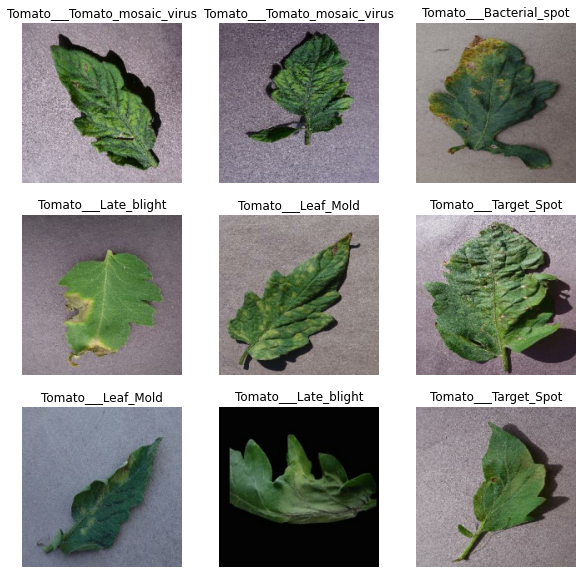

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in entrenados2.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(nombre_clases[labels[i]])
    plt.axis("off")

Red CNN - MobileNetV2

In [ ]:
model_CNN = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
model_CNN.trainable = False
model_CNN.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
prediction_layer = tf.keras.layers.Dense(num_clases, activation='softmax')

model_CNN_2 = tf.keras.Sequential([
  model_CNN,
  global_average_layer,
  prediction_layer
])

In [ ]:
model_CNN_2.summary()
print("number of layers to train: ", len(model_CNN_2.trainable_variables))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________
number of layers to train:  2


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001)
model_CNN_2.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                           patience=2, 
                           mode='auto',
                           restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              mode='auto')

In [ ]:
 history =  model_CNN_2.fit_generator(generator=entrenados, 
                        steps_per_epoch=pasos_entrenamiento,
                        validation_data=validados,
                        validation_steps=pasos_validacion,
                        epochs=10,
                        callbacks=[early_stop, reduce_lr]
                        )

<ipython-input-36-c63b0e33f746>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =  model_CNN_2.fit_generator(generator=entrenados,


Epoch 1/10
125/125 [==============================] - 668s 5s/step - loss: 2.5756 - accuracy: 0.1925 - val_loss: 1.7655 - val_accuracy: 0.3332 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 704s 6s/step - loss: 1.6017 - accuracy: 0.4496 - val_loss: 1.5043 - val_accuracy: 0.4622 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 721s 6s/step - loss: 1.2945 - accuracy: 0.5564 - val_loss: 1.0891 - val_accuracy: 0.6376 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 662s 5s/step - loss: 1.0678 - accuracy: 0.6355 - val_loss: 1.0034 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 661s 5s/step - loss: 1.0410 - accuracy: 0.6392 - val_loss: 0.9023 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 657s 5s/step - loss: 0.9975 - accuracy: 0.6660 - val_loss: 0.8186 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 7/10
125/125 [==============================] - 674s 5s/st

Análisis de Resultados - Accuracy

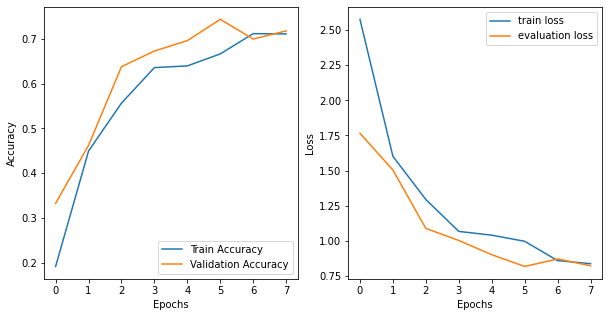

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
!mkdir -p modelos
model_CNN_2.save('modelos/mobilenetnoShu2.h5')

Mejorando accuracy

In [ ]:
modelnoshu2 = tf.keras.models.load_model('modelos/mobilenetnoShu2.h5')

In [ ]:
modelnoshu2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                           patience=3, 
                           mode='auto',
                           restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              mode='auto')

In [ ]:
 history =  modelnoshu2.fit_generator(generator=entrenados, 
                        steps_per_epoch=pasos_entrenamiento,
                        validation_data=validados,
                        validation_steps=pasos_validacion,
                        epochs=10,
                        callbacks=[early_stop, reduce_lr]
                        )

<ipython-input-97-57f50178fb15>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =  modelnoshu2.fit_generator(generator=entrenados,


Epoch 1/10
125/125 [==============================] - 627s 5s/step - loss: 2.3649 - accuracy: 0.2449 - val_loss: 1.9952 - val_accuracy: 0.2465 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 639s 5s/step - loss: 1.6032 - accuracy: 0.4454 - val_loss: 1.3870 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 641s 5s/step - loss: 1.2465 - accuracy: 0.5811 - val_loss: 1.2126 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 620s 5s/step - loss: 1.1373 - accuracy: 0.6145 - val_loss: 0.9630 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 641s 5s/step - loss: 1.1045 - accuracy: 0.6274 - val_loss: 0.9061 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 628s 5s/step - loss: 0.9312 - accuracy: 0.6854 - val_loss: 0.7936 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 7/10
125/125 [==============================] - 623s 5s/st

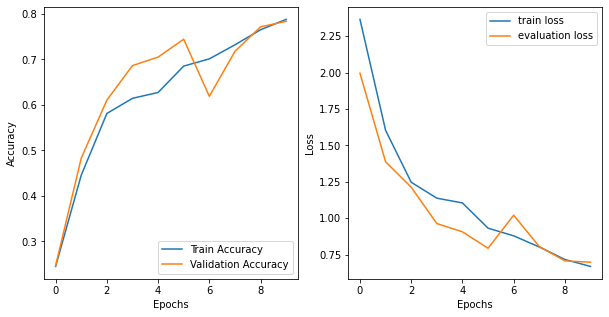

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
modelnoshu2.save('modelos/mobilenetnoShu2MOD.h5')

In [ ]:
modelnoshu2 = tf.keras.models.load_model('modelos/mobilenetnoShu2MOD.h5')